# Quantile Regression

Most common Machine Learning techniques are focused on generating predictions 
about an output but usually give no information about the confidence of such outcome,
this seems to be specially true in Deep Learning where rarely you get statistical 
properties for your model. There are however ways around this, once such way which we
will be exploring here is called **Quantile Regression**, this technique will allow us to learn
some very important statistical properties of our data: the quantiles.

To begin our journey into quantile regression we will first get hold on some data:

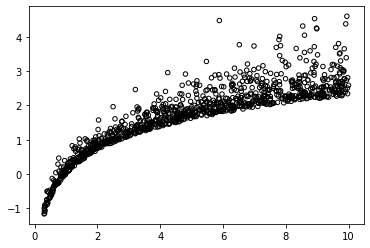

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def create_data(multimodal: bool):
    x = np.random.uniform(0.3, 10, 1000)
    y = np.log(x) + np.random.exponential(0.1 + x / 20.0)

    if multimodal:
        x = np.concatenate([x, np.random.uniform(5, 10, 500)])
        y = np.concatenate([y, np.random.normal(6.0, 0.3, 500)])

    return x[..., None], y[..., None]


multimodal: bool = False

x, y = create_data(multimodal)

fig = plt.figure()
plt.scatter(x[..., 0], y[..., 0], s=20, facecolors="none", edgecolors="k")
plt.show()

We have a simple 2D dataset however we should notice that `y` has some very peculiar statistical properties:

1. It is not normally distributed, infact it is exponentially distributed.
2. The previous also means its noise it not symetric. 
3. Its variance is not constant, it increases as `x` increases.

When making prediction for this kind of data we might be very interested to know what are
the lower and upper bounds our data revolves around such that we can judge if a specific
outcome is expected or not, what are the best and worst case scenarios for a particular variable,
etc.

## Quantile Loss
The only thing special about quantile regression really is its loss function, instead of the
usual L1 or L2 expression we use the following formula:

$$
\begin{aligned}
    E &= y - f(x) \\
    L_q &= \begin{cases}
        q  E,     &    E \gt 0  \\
        (1 - q) (-E), &    E \lt 0
    \end{cases}
\end{aligned}
$$

Here $E$ is the error term and $L_q$ is the loss function for the quantile $q$. So what
do we mean by this? Concretely it means that $L_q$ will bias $f(x)$ to output the value
of the $q$'th quantile instead of the usual mean or median statistic. How does it do it?

First lets notice that this formula can be rewritten as follows: 111

$$
\begin{aligned}
    E &= y - f(x) \\
    L_q &= \max \begin{cases}
        q  E   \\
        (q - 1) E
    \end{cases}
\end{aligned}
$$

Using $\max$ instead of a conditional statement will make it easier implement on tensor/array
libraries, we will do this next in jax.

In [2]:
import jax
import jax.numpy as jnp


def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return jnp.maximum(q * e, (q - 1.0) * e)

## Loss Landscape
Now that we have this lets explore the error landscape for a particular set of predictions.
Here we will generate values in the interval $[10, 20]$ and for a particular value of 
$q$ (0.8 by default) we will compute the total error for all values that $f(x)$ could take 
within this range.

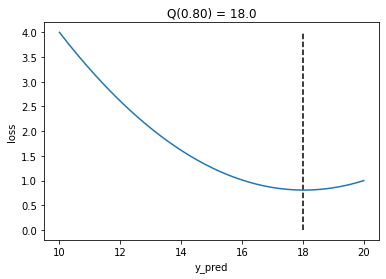

In [3]:


def calculate_error(q):
    y_true = np.linspace(10, 20, 100)
    y_pred = np.linspace(10, 20, 200)

    loss = jax.vmap(quantile_loss, in_axes=(None, None, 0))(q, y_true, y_pred)
    loss = loss.mean(axis=1)

    return y_true, y_pred, loss


q = 0.8
y_true, y_pred, loss = calculate_error(q)
q_true = np.quantile(y_true, q)

fig = plt.figure()
plt.plot(y_pred, loss)
plt.vlines(q_true, 0, loss.max(), linestyles="dashed", colors="k")
plt.gca().set_xlabel("y_pred")
plt.gca().set_ylabel("loss")
plt.title(f"Q({q:.2f}) = {q_true:.1f}")
plt.show()

What we see is that the minumum of this function is exactly $q$. It achieves this because
the quantile loss is not symetrical, for quantiles above `0.5` it penalizes positive 
errors stronger than negative errors, and the opposite is true for quantiles below `0.5`.
In particular, quantile `0.5` is the median and its formula is equivalent to the L1 loss.

## Deep Quantile Regression

Generally you would have to a model per quantile, however if we use a neural network
we can have it output the predictions for all the quantiles at the same time while
sharing the same backbone. Here will use `elegy` to create a neural network
with 2 hidden layers with `relu` activation and then a linear layers with `n_quantiles` output
units. 

In [4]:
import elegy


class QuantileRegression(elegy.Module):
    def __init__(self, n_quantiles: int):
        super().__init__()
        self.n_quantiles = n_quantiles

    def call(self, x):
        x = elegy.nn.Linear(128)(x)
        x = jax.nn.relu(x)
        x = elegy.nn.Linear(64)(x)
        x = jax.nn.relu(x)
        x = elegy.nn.Linear(self.n_quantiles)(x)

        return x

Now we are going to properly define a `QuantileLoss` class that is parameterized by
a set of user defined `quantiles`.

In [5]:


class QuantileLoss(elegy.Loss):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = np.array(quantiles)

    def call(self, y_true, y_pred):
        loss = jax.vmap(quantile_loss, in_axes=(0, None, -1), out_axes=1)(
            self.quantiles, y_true[:, 0], y_pred
        )
        return jnp.sum(loss, axis=-1)

Finally we are going to create a simple function that creates and trains our model for a
set of quantiles using `elegy`.

In [6]:
import optax


def train_model(quantiles, epochs: int, lr: float, eager: bool):
    model = elegy.Model(
        QuantileRegression(n_quantiles=len(quantiles)),
        loss=QuantileLoss(quantiles),
        optimizer=optax.adamw(lr),
        run_eagerly=eager,
    )
    model.init(x, y)
    model.summary(x)

    model.fit(x, y, epochs=epochs, batch_size=64, verbose=0)

    return model


if not multimodal:
    quantiles = (0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95)
else:
    quantiles = np.linspace(0.05, 0.95, 9)

model = train_model(quantiles=quantiles, epochs=3001, lr=1e-4, eager=False)

Now lets generate some test data that spans the entire domain and computre the predicted
quantiles.

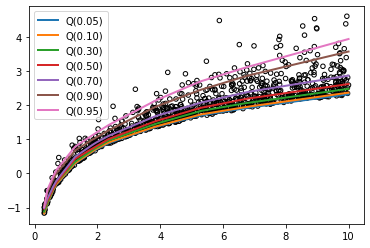

In [7]:
x_test = np.linspace(x.min(), x.max(), 100)
y_pred = model.predict(x_test[..., None])

fig = plt.figure()
plt.scatter(x, y, s=20, facecolors="none", edgecolors="k")

for i, q_values in enumerate(np.split(y_pred, len(quantiles), axis=-1)):
    plt.plot(x_test, q_values[:, 0], linewidth=2, label=f"Q({quantiles[i]:.2f})")

plt.legend()
plt.show()

Amazing! Notice how the first few quantiles are tightly packed together while the 
last ones spread out capturing the behavior of the exponential distribution.

In [8]:
def get_pdf(quantiles, q_values):
    densities = []

    for i in range(len(quantiles) - 1):
        area = quantiles[i + 1] - quantiles[i]
        b = q_values[i + 1] - q_values[i]
        a = area / b

        densities.append(a)

    return densities


def piecewise(xs):
    return [xs[i + j] for i in range(len(xs) - 1) for j in range(2)]


def doubled(xs):
    return [np.clip(xs[i], 0, 3) for i in range(len(xs)) for _ in range(2)]

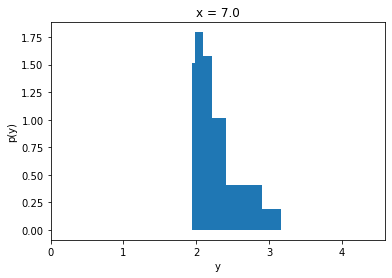

In [9]:
xi = 7.0

q_values = model.predict(np.array([[xi]]))[0].tolist()

densities = get_pdf(quantiles, q_values)


plt.title(f"x = {xi}")
plt.fill_between(piecewise(q_values), 0, doubled(densities))
# plt.fill_between(q_values, 0, densities + [0])
# plt.plot(q_values, densities + [0], color="k")
plt.xlim(0, y.max())
plt.gca().set_xlabel("y")
plt.gca().set_ylabel("p(y)")
plt.show()